## Splitting the database

In [1]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from statistics import mean
from langdetect import detect

df = pd.read_csv('PreProcessedData.csv', sep=',', names=['id','title','text','type'], header=None, skiprows=2,)
df.pop(df.columns[0])

0            1
1            2
2            3
3            4
4            5
         ...  
69039    69040
69040    69041
69041    69042
69042    69043
69043    69044
Name: id, Length: 69044, dtype: int64

In [2]:
def convert_labels(target: pd.Series) -> pd.Series:
    return pd.Series(np.where(target == 'fake', 0, 1))

df['type'] = convert_labels(df['type'])
df.head()

,title,text,type
0,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,0
1,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,0
2,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,1
3,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,1
4,Here Is Why the Trump Administration Will Be a...,Originally appeared at The American Conservati...,0


In [3]:
train, test, validation = np.split(df, [int(len(df) * 0.6), int(len(df) * 0.8)])
train.head()

,title,text,type
0,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,0
1,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,0
2,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,1
3,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,1
4,Here Is Why the Trump Administration Will Be a...,Originally appeared at The American Conservati...,0


## Replacing NA and changing formats

In [4]:
# How many of them have either title na or text na and if any have both
print(len(train[train['title'].isna() | train['text'].isna()]))
print(len(train[train['title'].isna() & train['text'].isna()]))

426
0


In [5]:
# let's replace na values in title & text columns with an empty string
def replace_na(df):
    _df = df.copy()
    _df['title'] = _df['title'].fillna('')
    _df['text'] = _df['text'].fillna('')
    _df.loc[df['text'].str.isspace() | _df['title'].str.isspace(), 'text'] = ''
    return _df

train_copy = train.copy()
train_copy = replace_na(train_copy)

# Dropping duplicates

In [6]:
def drop_duplicates(df):
    return df.drop_duplicates()

In [7]:
count_before = len(train_copy)
train_copy = drop_duplicates(train_copy)
print('Dropped', count_before - len(train_copy), 'duplicates')

Dropped 3503 duplicates


## Removing rows written in language different than English

In [8]:
def detect_language(row):
    try:
        return detect(row['title'])
    except:
        try:
            return detect(row['text'])
        except:
            return ''

def remove_other_languages(df):
    _df = df.copy()
    _df['language'] = _df['text']
    _df['language'] =_df.apply(lambda row: detect_language(row), axis=1)
    bad_rows_count = len(_df[_df['language'] != 'en'])
    print(f'There are', bad_rows_count, 'rows with a language different than English')
    _df = _df.drop(_df[_df.language != 'en'].index)
    _df = _df.drop('language', axis=1)
    return _df

In [9]:
train_copy = remove_other_languages(train_copy)
train_copy.head()

There are 1631 rows with a language different than English


,title,text,type
1,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,0
2,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,1
3,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,1
4,Here Is Why the Trump Administration Will Be a...,Originally appeared at The American Conservati...,0
5,Trump health pick favors insurance for people ...,(Reuters) - President Donald Trump’s nominee t...,1


## Generating additional columns

In [10]:
def count_capital_letters_part(title):
    capital_letters = 0
    c: str
    for c in title:
        if c.isupper():
            capital_letters += 1

    return capital_letters / len(title) if len(title) > 0 else 0

def count_punctuation_marks_per_char(text):
    if len(text) == 0:
        return 0
    return (text.count('?') +
            text.count('!') +
            text.count('.') +
            text.count(',') +
            text.count(':') +
            text.count('-') +
            text.count('"') +
            text.count(';')) / len(text)

def avg_word_length(text):
    words = text.split()

    if len(words) == 0:
        return 0

    return mean([len(word) for word in words])

reliable_sources = ['Reuters', 'CNN']
reliable_sources = [f'({x})' for x in reliable_sources]
spam_phrases = ['FOLLOW', 'CLICK', 'SUBSCRIBE', 'FREE']

def generate_metadata_columns(df): 
    _df = df.copy()
    _df['title_length'] = _df['title'].str.len()
    _df['capital_letters_part'] = _df['title'].apply(count_capital_letters_part)
    _df['trustworthy_source'] = (_df['text'].str.contains('|'.join(reliable_sources), regex=True)).astype('int')
    _df['link_count'] = _df['text'].str.count('#') + _df['text'].str.count('http') + _df['text'].str.count('@')
    _df['spam_phrases'] = _df['text'].str.contains('|'.join(spam_phrases)).astype('int')
    _df['punctuation_marks_per_char'] = _df['text'].apply(count_punctuation_marks_per_char)
    _df['avg_word_length'] = _df['text'].apply(avg_word_length)
    return _df[['title_length',
                'capital_letters_part', 
                'trustworthy_source', 
                'link_count', 
                'spam_phrases', 
                'punctuation_marks_per_char',
                'avg_word_length', 
                'type']]

In [11]:
train_copy = generate_metadata_columns(train_copy)
train_copy.head()

/var/folders/l_/7bmr3bvd63v8fld1s2fcmh7w0000gn/T/ipykernel_62568/1885311886.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  _df['trustworthy_source'] = (_df['text'].str.contains('|'.join(reliable_sources), regex=True)).astype('int')


,title_length,capital_letters_part,trustworthy_source,link_count,spam_phrases,punctuation_marks_per_char,avg_word_length,type
1,82,0.426829,0,0,0,0.019243,5.199203,0
2,61,0.049180,1,0,0,0.010152,5.030612,1
3,63,0.079365,1,0,0,0.016529,5.173469,1
4,83,0.144578,0,0,0,0.029577,5.290065,0
5,64,0.015625,1,0,0,0.023769,5.200000,1


array([[<Axes: title={'center': 'title_length'}>,
        <Axes: title={'center': 'capital_letters_part'}>,
        <Axes: title={'center': 'trustworthy_source'}>],
       [<Axes: title={'center': 'link_count'}>,
        <Axes: title={'center': 'spam_phrases'}>,
        <Axes: title={'center': 'punctuation_marks_per_char'}>],
       [<Axes: title={'center': 'avg_word_length'}>,
        <Axes: title={'center': 'type'}>, <Axes: >]], dtype=object)

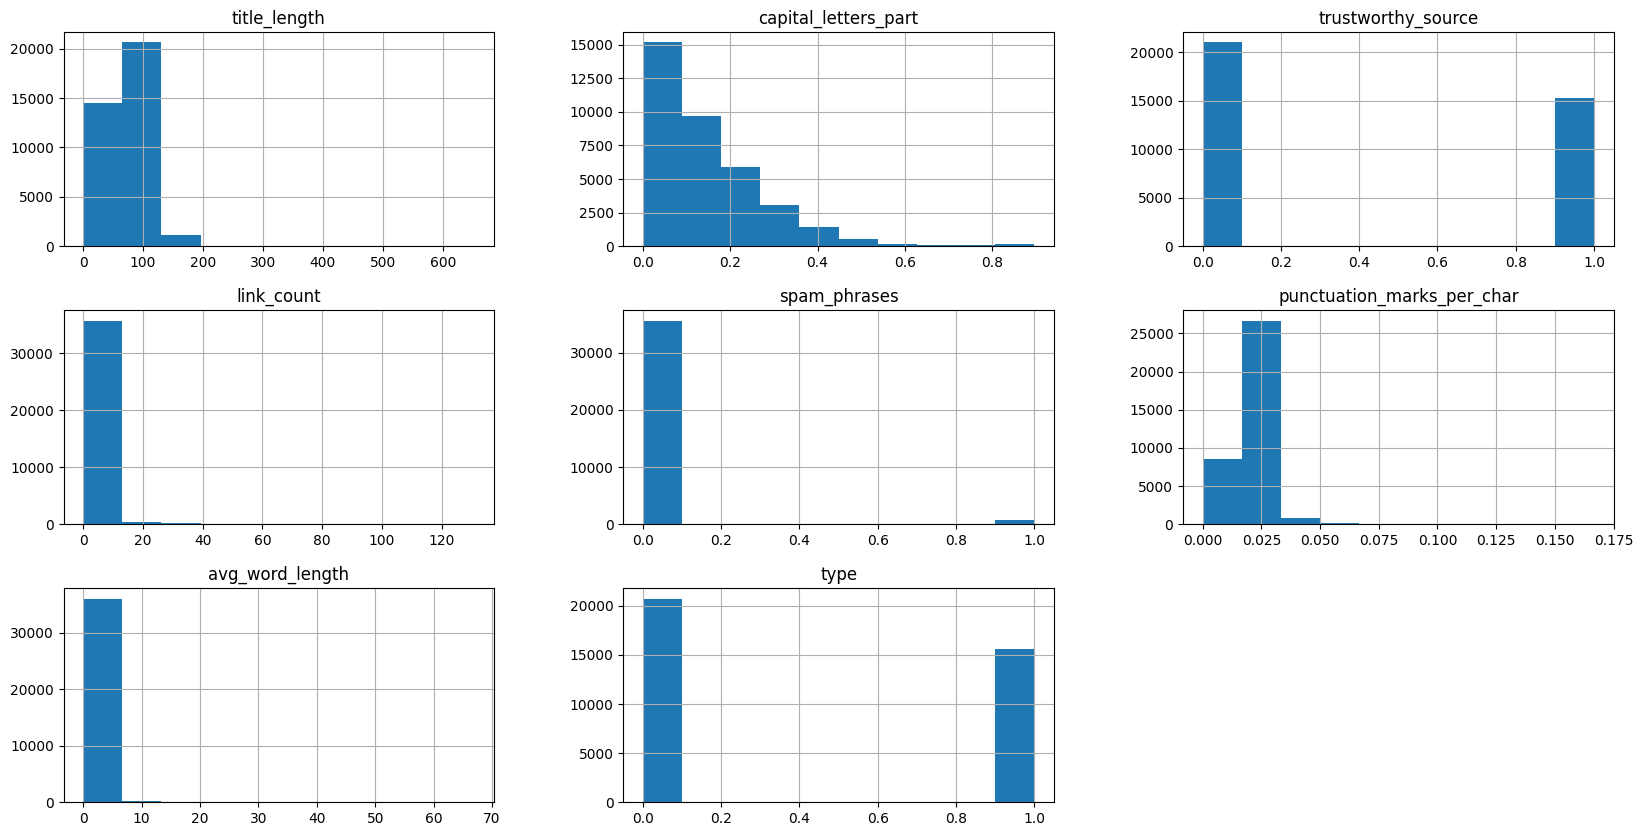

In [12]:
import matplotlib.pyplot as plt
train_copy.hist(figsize=(20,10))

<Axes: >

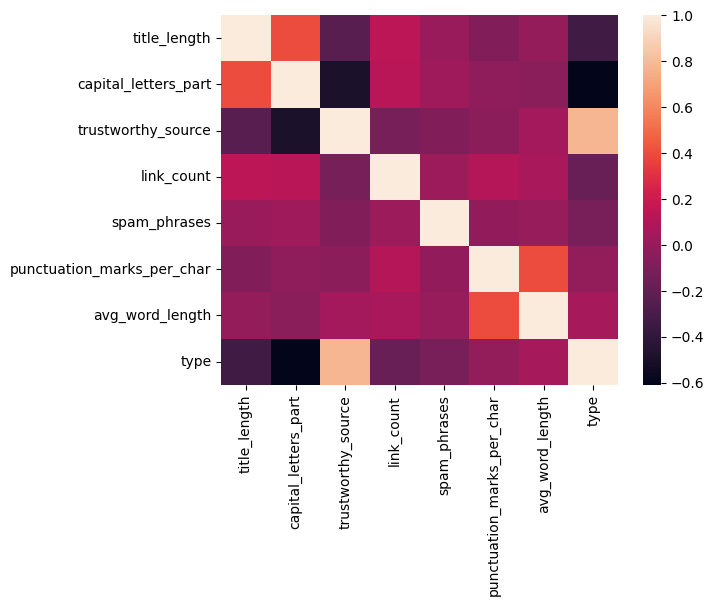

In [13]:
import seaborn as sns
sns.heatmap(train_copy.corr())

## Gini

In [14]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [15]:
for i in train_copy.columns:
    print(i, "", gini(train_copy[i]))

title_length  0.17936792987049172
capital_letters_part  0.4367796560586575
trustworthy_source  0.5789981263088284
link_count  0.9261528339495406
spam_phrases  0.9806568940813403
punctuation_marks_per_char  0.1597441415351547
avg_word_length  0.05723129305665818
type  0.5708420588559462


## Standardization

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def standardize(df):
    _df = df.copy()
    _df.loc[:, df.columns != "type"] = scaler.fit_transform(_df.loc[:,df.columns != "type"].values)
    return df

### Preprocess function

In [17]:
def preprocess(df, remove_languages=True):
    _df = df.copy()
    _df = replace_na(_df)
#     if remove_languages:                  # this has to be done outside of this function to make sure that both metadata and tf-idf classifier  remove the exact same rows
#         _df = remove_other_languages(_df)
    _df = generate_metadata_columns(_df)
    _df = standardize(_df)
    return _df

In [18]:
train_english = replace_na(train)
train_english = remove_other_languages(train_english)
df = preprocess(train_english)
df.head()

There are 1797 rows with a language different than English


/var/folders/l_/7bmr3bvd63v8fld1s2fcmh7w0000gn/T/ipykernel_62568/1885311886.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  _df['trustworthy_source'] = (_df['text'].str.contains('|'.join(reliable_sources), regex=True)).astype('int')


,title_length,capital_letters_part,trustworthy_source,link_count,spam_phrases,punctuation_marks_per_char,avg_word_length,type
1,82,0.426829,0,0,0,0.019243,5.199203,0
2,61,0.049180,1,0,0,0.010152,5.030612,1
3,63,0.079365,1,0,0,0.016529,5.173469,1
4,83,0.144578,0,0,0,0.029577,5.290065,0
5,64,0.015625,1,0,0,0.023769,5.200000,1


## Model

In [19]:
from sklearn.ensemble import RandomForestClassifier

target = df['type']
X_train_metadata = df.drop('type', axis=1)

metadata_classifier = RandomForestClassifier()

metadata_classifier.fit(X_train_metadata, target)

RandomForestClassifier()

## Prediction

In [20]:
from sklearn.metrics import classification_report

df_test = preprocess(test, remove_languages=False)
X_test = df_test.drop('type', axis=1)
y_test = df_test['type']

metadata_pred = metadata_classifier.predict(X_test)

print(classification_report(y_test, metadata_pred))

X_test.head()

/var/folders/l_/7bmr3bvd63v8fld1s2fcmh7w0000gn/T/ipykernel_62568/1885311886.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  _df['trustworthy_source'] = (_df['text'].str.contains('|'.join(reliable_sources), regex=True)).astype('int')


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      8551
           1       0.94      0.90      0.92      5258

    accuracy                           0.94     13809
   macro avg       0.94      0.93      0.94     13809
weighted avg       0.94      0.94      0.94     13809



,title_length,capital_letters_part,trustworthy_source,link_count,spam_phrases,punctuation_marks_per_char,avg_word_length
41426,109,0.458716,0,0,0,0.020740,4.915984
41427,96,0.197917,0,1,0,0.013040,5.154734
41428,67,0.164179,0,0,0,0.021449,5.187500
41429,79,0.177215,0,0,0,0.019397,4.395872
41430,29,0.310345,1,3,0,0.016908,5.402055


## Tf-Idf

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


def tfidf(column: pd.Series) -> tuple[TfidfVectorizer, pd.DataFrame]:
    vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]+\b', # exclude digits
                                 stop_words=list(ENGLISH_STOP_WORDS)) # exclude stop words
    sparse_matrix = vectorizer.fit_transform(column.str.lower())
    feature_names = vectorizer.get_feature_names_out()
    
    return vectorizer, pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=feature_names)

def transform_title_columns(columns):
    return [col + '_tit1e' for col in columns] # tit1e with 1 because digits are ignored by the vectorizer so adding a digit to a column name guarantess its uniqueness

def generate_tfidf_columns(df) -> tuple[pd.DataFrame, TfidfVectorizer, TfidfVectorizer]:
    text_vectorizer, text_tfidf = tfidf(df['text'])

    title_vectorizer, title_tfidf = tfidf(df['title'])
    title_tfidf.columns = transform_title_columns(title_tfidf.columns)
    
    X_train = pd.concat([title_tfidf, text_tfidf], axis=1)
    
    return X_train, title_vectorizer, text_vectorizer
    
def apply_vectorizers_to_test(X_test: pd.DataFrame, title_vectorizer, text_vectorizer) -> pd.DataFrame:
    vectorized_title = title_vectorizer.transform(X_test['title'])
    X_title = pd.DataFrame.sparse.from_spmatrix(vectorized_title, 
                                                columns=title_vectorizer.get_feature_names_out())
    X_title.columns = transform_title_columns(X_title.columns)
    
    vectorized_text = text_vectorizer.transform(X_test['text'])
    X_text = pd.DataFrame.sparse.from_spmatrix(vectorized_text, 
                                               columns=text_vectorizer.get_feature_names_out())
    
    return pd.concat([X_title, X_text], axis=1)


In [22]:
train_preprocessed = train_english.copy()
test_preprocessed = replace_na(test)
y_train = train_preprocessed['type']
y_test = test_preprocessed['type']
y_train = train_preprocessed['type']
y_test = test_preprocessed['type']
    
    
X_train_tfidf, title_vectorizer, text_vectorizer = generate_tfidf_columns(train_preprocessed)
X_test = apply_vectorizers_to_test(test_preprocessed, title_vectorizer, text_vectorizer)

# classifier
from sklearn.ensemble import RandomForestClassifier
tfidf_classifier = RandomForestClassifier()
tfidf_classifier.fit(X_train_tfidf, y_train)

tfidf_pred = tfidf_classifier.predict(X_test)

In [23]:
print(classification_report(tfidf_pred, y_test))
print(X_train_tfidf.shape)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      8929
           1       0.89      0.96      0.92      4880

    accuracy                           0.94     13809
   macro avg       0.93      0.95      0.94     13809
weighted avg       0.94      0.94      0.94     13809

(39629, 145949)


## Naive attempt of merging classifiers

Based on classification reports, we came up with a naive way to merge classifiers, which is based on the fact that the tfidf classifier turned out to be very precise when predicting 0 and the metadata classifier was more precise when predicting 1.

In [24]:
def final_classification(row):
    if row['tfidf_pred'] == 0:
        return 0
    if row['metadata_pred'] == 1:
        return 1
       
    return 0

stacked = np.vstack((tfidf_pred, metadata_pred)).transpose()
print(stacked[:10])

final_df = pd.DataFrame(stacked, columns = ['tfidf_pred', 'metadata_pred'])
y_pred = final_df.apply(lambda row: final_classification(row), axis=1)
print(classification_report(y_pred, y_test))

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      9311
           1       0.85      0.99      0.91      4498

    accuracy                           0.94     13809
   macro avg       0.92      0.95      0.93     13809
weighted avg       0.95      0.94      0.94     13809



## Merging classifier using another classifier

In [25]:
y_train_metadata_pred = metadata_classifier.predict(X_train_metadata)
y_train_tfidf_pred = tfidf_classifier.predict(X_train_tfidf)

In [26]:
stacked = np.vstack([y_train_tfidf_pred, y_train_metadata_pred]).transpose()
merged_train_preds = pd.DataFrame(stacked, columns=['tfidf_pred', 'metadata_pred'])
merged_train_preds.head()

,tfidf_pred,metadata_pred
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1


In [27]:
final_classifier = RandomForestClassifier()
final_classifier.fit(merged_train_preds, y_train)

RandomForestClassifier()

In [28]:
y_pred_final = final_classifier.predict(final_df)

In [29]:
print(classification_report(y_pred_final, y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      8424
           1       0.94      0.92      0.93      5385

    accuracy                           0.95     13809
   macro avg       0.94      0.94      0.94     13809
weighted avg       0.95      0.95      0.95     13809

